<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22739 sha256=3b056d877f9852c904cada09d534fecce874204060792597875b9b95e25f1dee
  Stored in directory: /tmp/pip-ephem-wheel-cache-520pv1ys/wheels/80/18/31/a2d23e747f07511e10faf78e50ba7baacbd3e93d747a75327b
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [2]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

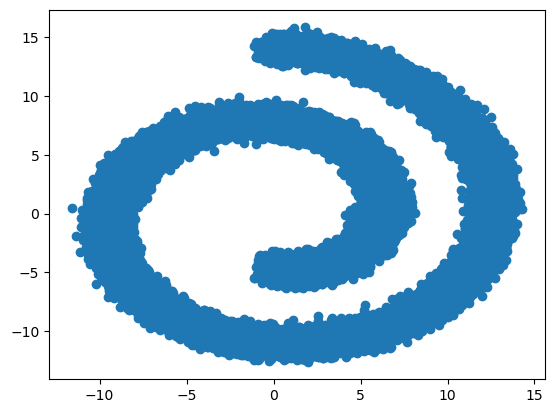

In [3]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, images size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size + 1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x, t):
        x = torch.cat([x, t], dim=1).to("cuda")
        return self.net(x)
def compute_alpha_sigma(t):
    alpha = torch.cos(np.pi / 2 * t)
    sigma = torch.sin(np.pi / 2 * t)
    return alpha, sigma

def forward_process(x, t):
    alpha, sigma = compute_alpha_sigma(t)
    epsilon = torch.randn_like(x)
    x_noised = alpha * x + sigma * epsilon
    return x_noised, epsilon

def evaluate(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, x_batch in enumerate(dataloader):
            x_batch = x_batch.to(device)
            t = torch.rand(x_batch.shape[0], 1, device=device)
            x_noised, epsilon = forward_process(x_batch, t)
            eps_hat = model(x_noised.to(device), t)
            loss = criterion(epsilon, eps_hat)
            total_loss += loss.item() * x_batch.size(0)
    return total_loss / len(dataloader.dataset)

def reverse_process(x, eps_hat, t, tm1, device='cuda'):
    alpha_t, sigma_t = compute_alpha_sigma(t)
    alpha_tm1, sigma_tm1 = compute_alpha_sigma(tm1)
    
    eta_t = (sigma_tm1 / sigma_t) * torch.sqrt(1 - (alpha_t.pow(2) / alpha_tm1.pow(2)))
    
    epsilon_t = torch.randn_like(x, device=device)
    
    x_tm1 = alpha_tm1 * ((x - sigma_t * eps_hat) / alpha_t) + \
            torch.sqrt(torch.maximum(sigma_tm1.pow(2) - eta_t.pow(2), torch.tensor(0., device=device))) * eps_hat + \
            eta_t * epsilon_t
    
    return x_tm1

def generate_samples(model, steps, device='cuda'):
    model.eval()
    all_samples = []

    for step in steps:
        x = torch.randn(2000, 2, device=device)  
        
        t_values = np.linspace(1 - 1e-4, 1e-4, step + 1)  
        for i in range(step):
            t = torch.full((2000, 1), t_values[i], device=device, dtype=torch.float32)
            tm1 = torch.full((2000, 1), t_values[i + 1], device=device, dtype=torch.float32) if i < step - 1 else torch.full((2000, 1), t_values[i], device=device, dtype=torch.float32)
            
            eps_hat = model(x, t)
            
            x = reverse_process(x, eps_hat, t, tm1, device)

        all_samples.append(x.detach().cpu().numpy())

    return np.array(all_samples) 

In [10]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """    
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)
    
    train_loader = DataLoader(train_tensor, batch_size=1024, shuffle=True)
    test_loader = DataLoader(test_tensor, batch_size=1024, shuffle=False)

    model = MLP().to("cuda")
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

  
    train_losses = []
    test_losses = [evaluate(model, test_loader, criterion)]


    num_epochs = 300
    for epoch in range(num_epochs):
        print(f"epoch {epoch}")
        model.train()
        for idx, x_batch in enumerate(train_loader):
            t = torch.rand(x_batch.shape[0], 1) 
            x_noised, epsilon = forward_process(x_batch, t)
            eps_hat = model(x_noised, t)
            epsilon = epsilon.to("cuda")
            loss = criterion(epsilon, eps_hat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        test_loss = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
    torch.save(model.state_dict(), 'model.pth')
    all_samples = generate_samples(model, steps=np.power(2, np.linspace(2, 10, 9)).astype(int))
    
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)

    return train_losses, test_losses, all_samples

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


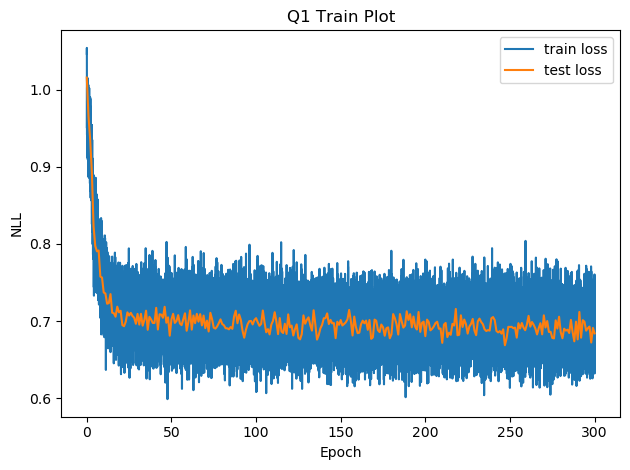

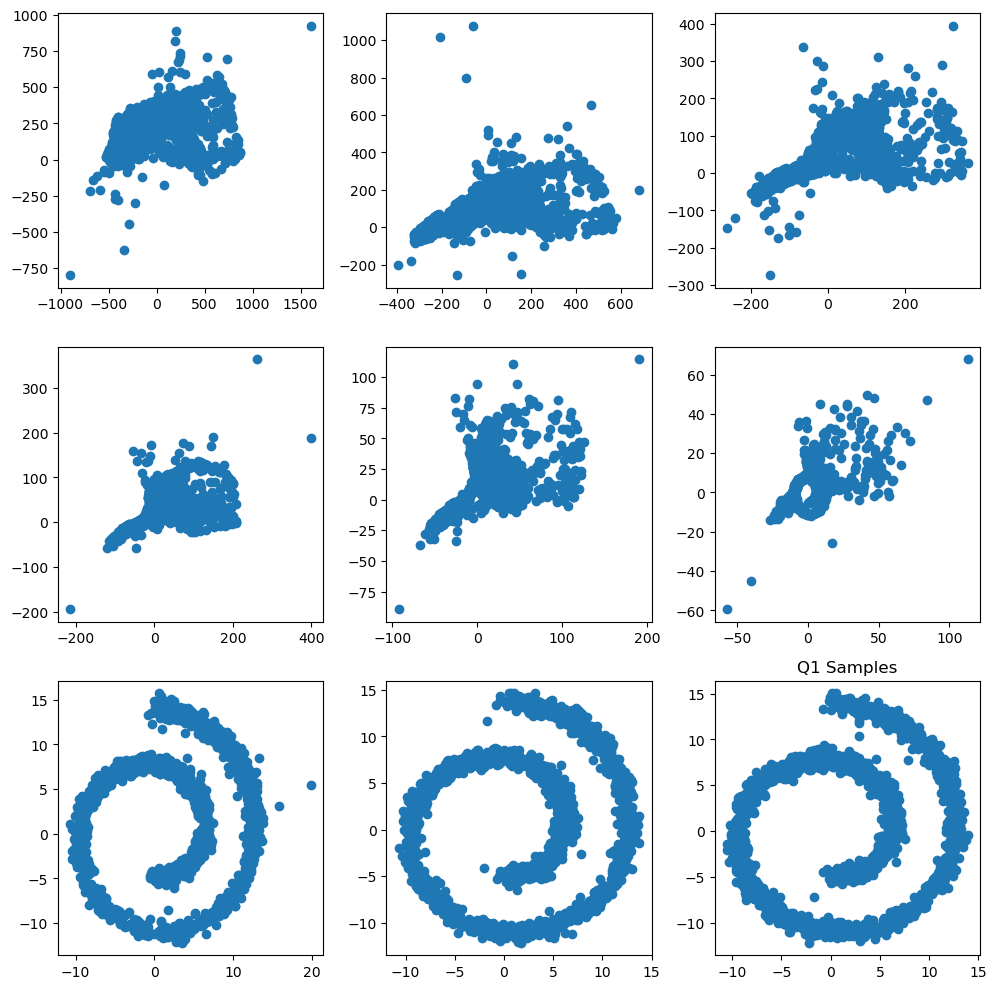

In [11]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

100%|██████████| 170498071/170498071 [01:06<00:00, 2574352.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


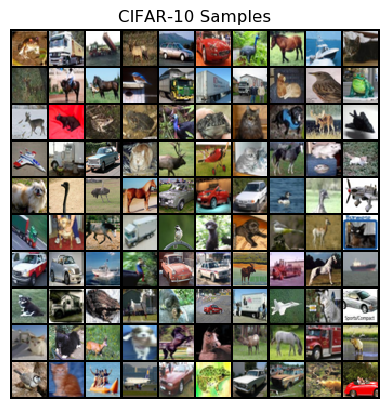

In [12]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [3]:
import torch.nn as nn

def timestep_embedding(timesteps, dim, max_period=10000):
    half_dim = dim // 2
    freqs = torch.exp(-np.log(max_period) * torch.arange(0, half_dim, dtype=torch.float32) / half_dim).to(timesteps.device)
    args = timesteps.to(freqs.dtype) * freqs
    embedding = torch.cat([torch.cos(args), torch.sin(args)], axis=-1).to(timesteps.device)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], axis=-1).to(timesteps.device)
    return embedding
# Define the ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.temb_proj = nn.Linear(temb_channels, out_channels)
        if in_channels != out_channels:
            self.proj_x = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x, temb):
        h = F.silu(self.norm1(self.conv1(x)))
        temb = self.temb_proj(temb)[:, :, None, None]
        h += temb
        h = F.silu(self.norm2(self.conv2(h)))
        if hasattr(self, 'proj_x'):
            x = self.proj_x(x)
        return x + h

# Define Downsample
class Downsample(nn.Module):
    def __init__(self, in_channels):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

# Define Upsample
class Upsample(nn.Module):
    def __init__(self, in_channels):
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)

    def forward(self, x):
        return self.conv(F.interpolate(x, scale_factor=2, mode='nearest'))

# Define UNet
class UNet(nn.Module):
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super(UNet, self).__init__()
        self.hidden_dims = hidden_dims
        self.blocks_per_dim = blocks_per_dim
        self.temb_channels = hidden_dims[0] * 4
        self.temb_proj = nn.Sequential(
            nn.Linear(hidden_dims[0], self.temb_channels),
            nn.SiLU(),
            nn.Linear(self.temb_channels, self.temb_channels)
        )
        self.initial_conv = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)
        
        self.down_blocks = nn.ModuleList()
        self.upsample_blocks = nn.ModuleList()
        self.downsamples = nn.ModuleList()
        self.upsamples = nn.ModuleList()

        self.down_block_chans = [hidden_dims[0]]

        prev_ch = hidden_dims[0]

        # Downsample path
        for i, hidden_dim in enumerate(hidden_dims):
            for _ in range(blocks_per_dim):
                # print(f"down res r {prev_ch} {hidden_dim}")
                self.down_blocks.append(ResidualBlock(prev_ch, hidden_dim, self.temb_channels))
                prev_ch = hidden_dim
                self.down_block_chans.append(prev_ch)
            if i != len(hidden_dims) - 1:
                # print(f"downsample {prev_ch}")
                self.downsamples.append(Downsample(prev_ch))
                self.down_block_chans.append(prev_ch)
        # print(f"self.downsamples {self.downsamples} self.down_blocks {self.down_blocks}")

        self.h1 = ResidualBlock(prev_ch, prev_ch, self.temb_channels)
        self.h2 = ResidualBlock(prev_ch, prev_ch, self.temb_channels)
        # print(f"self.down_block_chans {self.down_block_chans}")
        # Upsample path
        for i, hidden_dim in enumerate(reversed(hidden_dims)):
            for j in range(blocks_per_dim+1):
                dch = self.down_block_chans.pop()
                combined_channels = prev_ch + dch
                # print(f"{i} up res combined_channels{combined_channels} hidden_dim{hidden_dim}")
                self.upsample_blocks.append(ResidualBlock(combined_channels, hidden_dim, self.temb_channels))
                prev_ch = hidden_dim
                if i != len(hidden_dims) - 1 and j == blocks_per_dim:
                    self.upsamples.append(Upsample(hidden_dim))
        # print(f"self.upsamples {self.upsamples} self.upsample_blocks {self.upsample_blocks}")


        self.final_norm = nn.GroupNorm(8, prev_ch)
        self.final_conv = nn.Conv2d(prev_ch, in_channels, 3, padding=1)

    def forward(self, x, t):
        # print(x.shape, t.shape)
        temb = timestep_embedding(t, self.hidden_dims[0])
        # print(temb.shape)
        temb = self.temb_proj(temb)

        h = self.initial_conv(x)
        # print(f"h {h.shape}")
        hs = [h]

        # Downsample path
        # print(len(self.downsamples))
        block_idx = 0  # Initialize block index for accessing the correct ResidualBlock
        # Downsample path
        for i, hidden_dim in enumerate(self.hidden_dims):
            for j in range(self.blocks_per_dim):
                h = self.down_blocks[i*self.blocks_per_dim+j](h, temb)
                hs.append(h)
                # print(f"down block index {i} {j} {h.shape}")
            if i != len(self.hidden_dims) - 1:
                h = self.downsamples[i](h)
                # print(f"Downsample index {i} {j} {h.shape}")
                hs.append(h)
    
        # print(f"downsample finish {h.shape}")
        # Additional Residual Blocks at the bottleneck
        h = self.h1(h, temb)
        h = self.h2(h, temb)
        # print(f"Residual finish {h.shape}")
        # Upsample path
        for i, hidden_dim in enumerate(reversed(self.hidden_dims)):
            for j in range(self.blocks_per_dim+1):
                h_p = hs.pop()
                # print(f"up index {i} {j} {h_p.shape}")
                h = torch.cat([h, h_p], dim=1)
                # print(f"{i} {j} up res combined_channels{h.shape}")
                h = self.upsample_blocks[i*(self.blocks_per_dim+1)+j](h, temb)
                # print(f"{i} {j} up res output {h.shape}")
                prev_ch = hidden_dim
                # print(f" {i != len(hidden_dims) - 1} {j == blocks_per_dim}")
                if i != len(self.hidden_dims) - 1 and j == self.blocks_per_dim:
                    h = self.upsamples[i](h)
                    # print(f"{i} {j} upsamples {h.shape}")
        
        
        h = self.final_norm(h)
        h = F.silu(h)
        h = self.final_conv(h)
        return h
def compute_alpha_sigma(t):
    alpha = torch.cos(np.pi / 2 * t)
    sigma = torch.sin(np.pi / 2 * t)
    return alpha, sigma

def forward_process(x, t):
    alpha, sigma = compute_alpha_sigma(t)
    

    alpha = alpha.unsqueeze(-1).unsqueeze(-1) 
    sigma = sigma.unsqueeze(-1).unsqueeze(-1)  
    epsilon = torch.randn_like(x)
    print(alpha.shape, x.shape, sigma.shape, epsilon.shape)
    x_noised = alpha * x + sigma * epsilon
    return x_noised, epsilon

def evaluate(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, x_batch in enumerate(dataloader):
            # print(x_batch.shape)
            x_batch = x_batch.to(device)
            t = torch.rand(x_batch.shape[0], 1, device=device)
            x_noised, epsilon = forward_process(x_batch, t)
            # print(f"forward {x_noised.shape}")
            eps_hat = model(x_noised.to(device), t)
            loss = criterion(epsilon, eps_hat)
            total_loss += loss.item() * x_batch.size(0)
    return total_loss / len(dataloader.dataset)

def reverse_process(x, eps_hat, t, tm1, device='cuda'):
    alpha_t, sigma_t = compute_alpha_sigma(t)
    alpha_tm1, sigma_tm1 = compute_alpha_sigma(tm1)
    alpha_t = alpha_t.unsqueeze(-1).unsqueeze(-1)
    sigma_t = sigma_t.unsqueeze(-1).unsqueeze(-1)
    alpha_tm1 = alpha_tm1.unsqueeze(-1).unsqueeze(-1)
    sigma_tm1 = sigma_tm1.unsqueeze(-1).unsqueeze(-1)
    
    eta_t = (sigma_tm1 / sigma_t) * torch.sqrt(1 - (alpha_t.pow(2) / alpha_tm1.pow(2)))
    
    epsilon_t = torch.randn_like(x, device=device)
    
    x_h = torch.clamp((x - sigma_t * eps_hat) / alpha_t, -1, 1)
    x_tm1 = alpha_tm1 * (x_h) + \
            torch.sqrt(torch.maximum(sigma_tm1.pow(2) - eta_t.pow(2), torch.tensor(0., device=device))) * eps_hat + \
            eta_t * epsilon_t

    
    return x_tm1

def generate_samples(model, steps, device='cuda'):
    model.eval()
    all_samples = []

    with torch.no_grad(): 
        for step in steps:
            x = torch.randn(10, 3, 32, 32, device=device) 
            
            t_values = np.linspace(1 - 1e-4, 1e-4, step + 1)  
            for i in range(step):
                t = torch.full((10, 1), t_values[i], device=device, dtype=torch.float32)
                tm1 = torch.full((10, 1), t_values[i + 1], device=device, dtype=torch.float32) if i < step - 1 else torch.full((10, 1), t_values[i], device=device, dtype=torch.float32)
                eps_hat = model(x, t)
                # print(f"eps_hat {eps_hat.shape}")
                x = reverse_process(x, eps_hat, t, tm1, device)
    
            x_adjusted = (x + 1.0) / 2.0
            # x_adjusted = x
            x_adjusted = x_adjusted.permute((0, 2, 3, 1))
            
            x_adjusted = torch.clamp(x_adjusted, 0.0, 1.0)
            
            all_samples.append(x_adjusted.detach().cpu().numpy())

    return np.array(all_samples) 


In [15]:
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import math

In [18]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dims = [64, 128, 256, 512]
    blocks_per_dim = 2
    batch_size = 256
    num_epochs = 30
    
    model = UNet(in_channels=3, hidden_dims=hidden_dims, blocks_per_dim=blocks_per_dim).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    

    train_data = torch.tensor(train_data.transpose((0, 3, 1, 2)), dtype=torch.float32)
    test_data = torch.tensor(test_data.transpose((0, 3, 1, 2)), dtype=torch.float32)
    
    train_data = train_data * 2 - 1
    test_data = test_data * 2 - 1

    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()

    train_losses = []
    test_losses = [evaluate(model, test_loader, criterion)] 

    total_steps = len(train_loader) * num_epochs
    warmup_steps = 100
    lambda1 = lambda step: step / warmup_steps if step < warmup_steps \
        else 0.5 * (1 + torch.cos(torch.tensor(math.pi * (step - warmup_steps) / (total_steps - warmup_steps))))
    
    scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])
    
    for epoch in range(num_epochs):
        model.train()
        # progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as progress_bar:
            for idx, x_batch in progress_bar:
            # for idx, x_batch in enumerate(train_loader):
                t = torch.rand(x_batch.shape[0], 1).to("cuda") 
                x_batch = x_batch.to("cuda")
                x_noised, epsilon = forward_process(x_batch, t)
                eps_hat = model(x_noised, t)
                epsilon = epsilon.to("cuda")
                loss = criterion(epsilon, eps_hat)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                scheduler.step()
                
                train_losses.append(loss.item())
                # print(f"iter {idx}")
                # if idx > 1:
                #     break
                progress_bar.set_postfix({"loss": f"{loss.item():.6f}"})

        
        test_loss = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        print(f"epoch {epoch} eval loss {test_loss}")
    torch.save(model.state_dict(), 'model.pth')
    # 样本生成
    samples = generate_samples(model, steps=np.power(2, np.linspace(0, 9, 10)).astype(int))
    # print(train_losses, test_losses, all_samples)
    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/30: 100%|██████████| 196/196 [01:25<00:00,  2.30it/s, loss=0.076688]


epoch 0 eval loss 0.09469268146753311


Epoch 2/30: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s, loss=0.061823]


epoch 1 eval loss 0.07877151067256928


Epoch 3/30: 100%|██████████| 196/196 [01:27<00:00,  2.24it/s, loss=0.069702]


epoch 2 eval loss 0.07356031683683395


Epoch 4/30: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s, loss=0.080817]


epoch 3 eval loss 0.06965432032942771


Epoch 5/30: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, loss=0.058038]


epoch 4 eval loss 0.07093356003761292


Epoch 6/30: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=0.068178]


epoch 5 eval loss 0.06977473800182342


Epoch 7/30: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=0.055785]


epoch 6 eval loss 0.06812134484052658


Epoch 8/30: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, loss=0.086428]


epoch 7 eval loss 0.0686260895371437


Epoch 9/30: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.078657]


epoch 8 eval loss 0.06910815153121948


Epoch 10/30: 100%|██████████| 196/196 [01:20<00:00,  2.45it/s, loss=0.072234]


epoch 9 eval loss 0.06681168967485428


Epoch 11/30: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.074722]


epoch 10 eval loss 0.06699039596319199


Epoch 12/30: 100%|██████████| 196/196 [01:25<00:00,  2.30it/s, loss=0.106283]


epoch 11 eval loss 0.06584693397283554


Epoch 13/30: 100%|██████████| 196/196 [01:25<00:00,  2.28it/s, loss=0.084585]


epoch 12 eval loss 0.06675931004285812


Epoch 14/30: 100%|██████████| 196/196 [01:23<00:00,  2.35it/s, loss=0.063783]


epoch 13 eval loss 0.06629280400276184


Epoch 15/30: 100%|██████████| 196/196 [01:24<00:00,  2.33it/s, loss=0.052704]


epoch 14 eval loss 0.06604218206405639


Epoch 16/30: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.074601]


epoch 15 eval loss 0.06443554137945175


Epoch 17/30: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.075568]


epoch 16 eval loss 0.0623954696893692


Epoch 18/30: 100%|██████████| 196/196 [01:19<00:00,  2.45it/s, loss=0.043406]


epoch 17 eval loss 0.06243158218860626


Epoch 19/30: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s, loss=0.054160]


epoch 18 eval loss 0.0644847048997879


Epoch 20/30: 100%|██████████| 196/196 [01:24<00:00,  2.32it/s, loss=0.070511]


epoch 19 eval loss 0.06366069560050965


Epoch 21/30: 100%|██████████| 196/196 [01:25<00:00,  2.30it/s, loss=0.060628]


epoch 20 eval loss 0.06386976864337922


Epoch 22/30: 100%|██████████| 196/196 [01:25<00:00,  2.30it/s, loss=0.059249]


epoch 21 eval loss 0.06440472308993339


Epoch 23/30: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=0.063369]


epoch 22 eval loss 0.06339059140682221


Epoch 24/30: 100%|██████████| 196/196 [01:24<00:00,  2.33it/s, loss=0.053148]


epoch 23 eval loss 0.06328282335996628


Epoch 25/30: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=0.074171]


epoch 24 eval loss 0.06397127630710601


Epoch 26/30: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s, loss=0.062951]


epoch 25 eval loss 0.0632690725326538


Epoch 27/30: 100%|██████████| 196/196 [01:24<00:00,  2.31it/s, loss=0.053073]


epoch 26 eval loss 0.064227501142025


Epoch 28/30: 100%|██████████| 196/196 [01:26<00:00,  2.27it/s, loss=0.067128]


epoch 27 eval loss 0.06177759408950806


Epoch 29/30: 100%|██████████| 196/196 [01:26<00:00,  2.27it/s, loss=0.063355]


epoch 28 eval loss 0.0634564049422741


Epoch 30/30: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s, loss=0.045876]


epoch 29 eval loss 0.06316496722102165
Final Test Loss: 0.0632


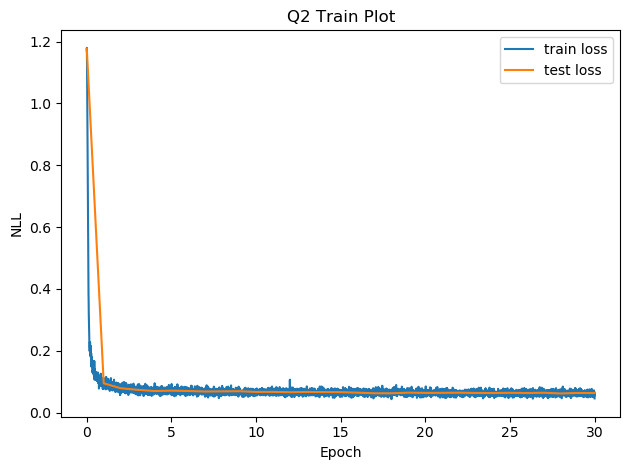

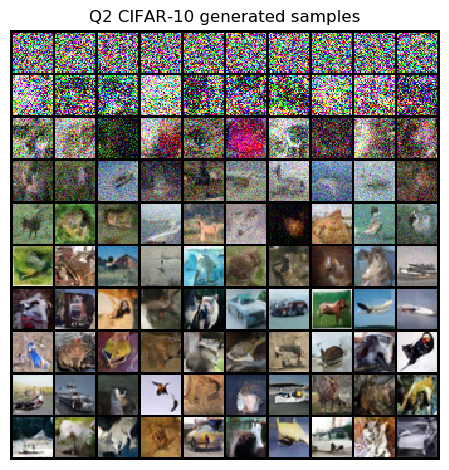

In [17]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


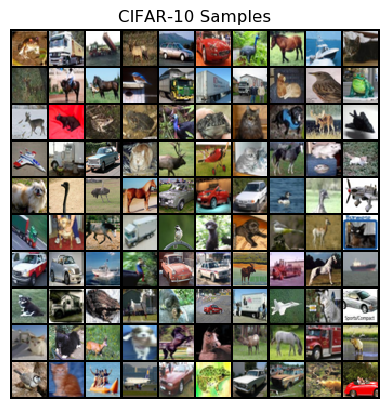

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [6]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [38]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """

    # data_loader = torch.utils.data.DataLoader(batch, batch_size=50, shuffle=True)
    # for i, batch in enumerate(data_loader):
    #   z = vae.encode(np.array(batch,dtype=np.float64))
    #   out_images = vae.decode(z)
    #   if(i == 0): encoded_images = out_images
    #   else: encoded_images +=batch
    images = np.transpose(images, (0, 3, 1, 2))
    images = np.array(images,dtype=np.float32)
    in_images = images[:50]
    z = vae.encode(images)
    encoded_images = vae.decode(z)
    encoded_images = encoded_images.cpu()
    out_images = np.array(encoded_images[:50])
    autoencoded_images = np.stack((in_images,out_images),axis=1)
    autoencoded_images = np.transpose(autoencoded_images,(0,1,3,4,2))
    flatten_images = encoded_images.flatten()
    scale_factor = np.std(np.array(flatten_images))

    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


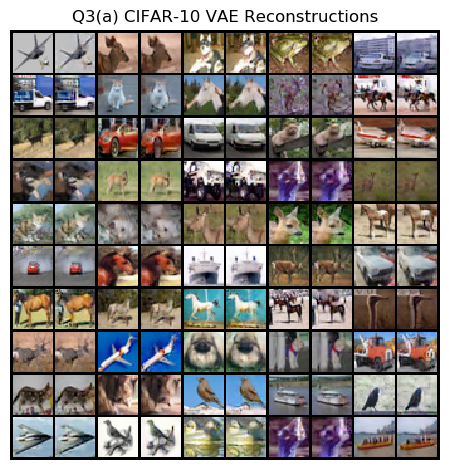

Scale factor: 0.2429


In [8]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [4]:
%pip install timm


Note: you may need to restart the kernel to use updated packages.


In [28]:

import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
from torch.optim.lr_scheduler import LambdaLR

device = torch.device('cuda')
def compute_alpha_sigma(t):
    alpha = torch.cos(np.pi / 2 * t)
    sigma = torch.sin(np.pi / 2 * t)
    return alpha, sigma

def forward_process(x, t):
    alpha, sigma = compute_alpha_sigma(t)

    alpha = alpha.unsqueeze(-1).unsqueeze(-1)  
    sigma = sigma.unsqueeze(-1).unsqueeze(-1)  
    epsilon = torch.randn_like(x)
    x_noised = alpha * x + sigma * epsilon
    return x_noised, epsilon
def reverse_process(x, eps_hat, t, tm1, device='cuda'):
    alpha_t, sigma_t = compute_alpha_sigma(t)
    alpha_tm1, sigma_tm1 = compute_alpha_sigma(tm1)
    alpha_t = alpha_t.unsqueeze(-1).unsqueeze(-1)
    sigma_t = sigma_t.unsqueeze(-1).unsqueeze(-1)
    alpha_tm1 = alpha_tm1.unsqueeze(-1).unsqueeze(-1)
    sigma_tm1 = sigma_tm1.unsqueeze(-1).unsqueeze(-1)
    
    eta_t = (sigma_tm1 / sigma_t) * torch.sqrt(1 - (alpha_t.pow(2) / alpha_tm1.pow(2)))
    
    epsilon_t = torch.randn_like(x, device=device)
    
    x_h = (x - sigma_t * eps_hat) / alpha_t
    x_tm1 = alpha_tm1 * (x_h) + \
            torch.sqrt(torch.maximum(sigma_tm1.pow(2) - eta_t.pow(2), torch.tensor(0., device=device))) * eps_hat + \
            eta_t * epsilon_t

    
    return x_tm1





def modulate(x, shift, scale):
    return x * (1 + scale) + shift


#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


#################################################################################
#                                 Core DiT Model                                #
#################################################################################

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size*6, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa.unsqueeze(1), scale_msa.unsqueeze(1)))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp.unsqueeze(1), scale_mlp.unsqueeze(1)))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift.unsqueeze(1), scale.unsqueeze(1))
        x = self.linear(x)
        return x


class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=8,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=10,
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t).squeeze(1)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)                       
        for block in self.blocks:
            x = block(x, c)                     # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    # def forward_with_cfg(self, x, t, y, cfg_scale):
    #     """
    #     Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
    #     """
    #     # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
    #     half = x[: len(x) // 2]
    #     combined = torch.cat([half, half], dim=0)
    #     model_out = self.forward(combined, t, y)
    #     # For exact reproducibility reasons, we apply classifier-free guidance on only
    #     # three channels by default. The standard approach to cfg applies it to all channels.
    #     # This can be done by uncommenting the following line and commenting-out the line following that.
    #     # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
    #     eps, rest = model_out[:, :3], model_out[:, 3:]
    #     cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
    #     half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
    #     eps = torch.cat([half_eps, half_eps], dim=0)
    #     return torch.cat([eps, rest], dim=1)


#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """
    epochs = 60
    batch_size = 256
    lr = 1e-3
    scale_factor = 0.2429
    train_data = 2*train_data-1 
    test_data = 2*test_data-1
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False, drop_last=True)
    model = DiT(patch_size=2,hidden_size=512,num_heads=8,depth=12)
    model.train()
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    criterion = nn.MSELoss()
    train_losses = np.array([])
    test_losses = np.array([])
    samples = np.array([])
    total_steps = len(train_loader) * epochs
    warmup_steps = 100
    lambda1 = lambda step: step / warmup_steps if step < warmup_steps \
        else 0.5 * (1 + math.cos(math.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
    scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])
    for i in range(epochs):
        total_loss = 0
        for j, images in enumerate(train_loader):
            images = np.transpose(images, (0, 3, 1, 2))
            images = np.array(images,dtype=np.float32)
            z = vae.encode(images).cuda()
            z = (z/scale_factor)
            y = torch.from_numpy(train_labels[batch_size*j:batch_size*(j+1)]).cuda()
            # images = torch.from_numpy(np.array(images,dtype=np.float32))
            t = torch.rand(z.shape[0], 1).to("cuda")
            z_noised, epsilon = forward_process(z, t)       
            result = model(z_noised,t,y)
            # epsilon = epsilon.to("cuda")
            loss = criterion(torch.cat([z_noised,epsilon],1), result)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            z = z*scale_factor
            encoded_images = vae.decode(z)
            total_loss += loss.item()
            train_losses = np.append(train_losses,loss.item())
        print("Train epoch: ", i+1," ", "loss: ",total_loss/(np.shape(train_data)[0]//batch_size))    
    model.eval()
    with torch.no_grad():
        for i in range(epochs):
            total_loss = 0
            for j, images in enumerate(test_loader):
                images = np.transpose(images, (0, 3, 1, 2))
                images = np.array(images,dtype=np.float32)
                z = vae.encode(images).cuda()
                z = (z/scale_factor)
                y = torch.from_numpy(test_labels[batch_size*j:batch_size*(j+1)]).cuda()
                t = torch.rand(z.shape[0], 1).to("cuda")
                z_noised, epsilon = forward_process(z, t)
                result = model(z_noised,t,y)
                loss = criterion(torch.cat([z_noised,epsilon],1), result)
                z = z*scale_factor
                encoded_images = vae.decode(z)
                total_loss += loss.item()
            test_losses = np.append(test_losses,total_loss/(np.shape(test_data)[0]//batch_size))
            print("Test epoch: ", i+1," ", "loss: ",total_loss/(np.shape(test_data)[0]//batch_size))    

        samples = torch.zeros((10,0,3,32,32)).cuda()
        steps=np.power(2, np.linspace(0, 9, 10)).astype(int)
        for step in steps:
            y = np.arange(10)
            x = torch.randn(10, 3, 32, 32).cuda() 
            z = vae.encode(x).cuda()
            y = torch.from_numpy(y).cuda()
            t_values = np.linspace(1 - 1e-4, 1e-4, step+1)

            for i in range(step):
                t = torch.full((10, 1), t_values[i], device=device, dtype=torch.float32).to("cuda")
                tm1 = torch.full((10, 1), t_values[i + 1], device=device, dtype=torch.float32).to("cuda") if i < step - 1 else torch.full((10, 1), t_values[i], device=device, dtype=torch.float32).to("cuda")
                result = model(z,t,y)
                z = reverse_process(result[:,:4,:,:], result[:,4:,:,:], t, tm1, device)

            # t = torch.rand(10, 1).to("cuda")
            # tm = torch.rand(10, 1).to("cuda")
            
            z = z*scale_factor
            encoded_images = vae.decode(z)
            encoded_images = torch.clamp(encoded_images,-1,1)
            samples = torch.cat([samples,encoded_images.unsqueeze(1)],1)
        samples = samples.cpu().detach().numpy()
        samples = (np.transpose(samples, (0, 1, 3, 4, 2))+1)/2
    torch.save(model.state_dict(), 'model_q3_b.pth')
    return train_losses, test_losses, samples

    

Files already downloaded and verified
Files already downloaded and verified
Train epoch:  1   loss:  1.797660934772247
Train epoch:  2   loss:  0.4370344592974736
Train epoch:  3   loss:  0.3972744732331007
Train epoch:  4   loss:  0.39276884488570385
Train epoch:  5   loss:  0.3918804128964742
Train epoch:  6   loss:  0.3878813875027192
Train epoch:  7   loss:  0.387965169778237
Train epoch:  8   loss:  0.38600759017161834
Train epoch:  9   loss:  0.38243631567710484
Train epoch:  10   loss:  0.38294081000181346
Train epoch:  11   loss:  0.3834281537777338
Train epoch:  12   loss:  0.7973476383930598
Train epoch:  13   loss:  1.8956621159345677
Train epoch:  14   loss:  0.43046008944511416
Train epoch:  15   loss:  0.3957370264407916
Train epoch:  16   loss:  0.3902149773561038
Train epoch:  17   loss:  0.3862479280202817
Train epoch:  18   loss:  0.384836147687374
Train epoch:  19   loss:  0.38246455972011273
Train epoch:  20   loss:  0.38065967911329024
Train epoch:  21   loss:  0.3

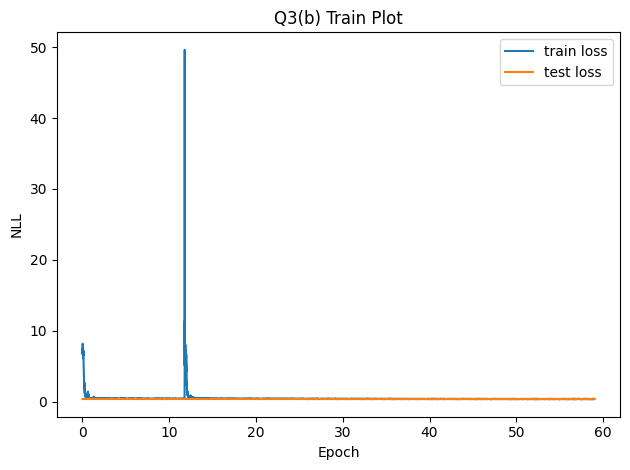

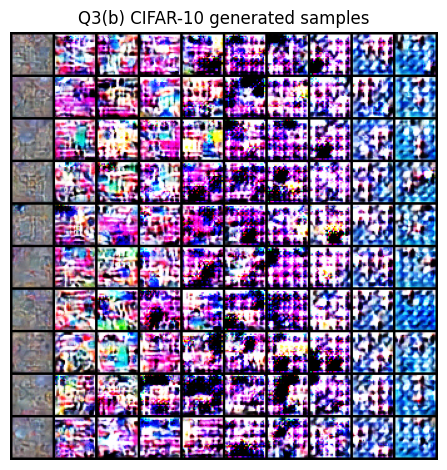

In [29]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [64]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """
    scale_factor = 0.2429

    samples_list = np.empty((0,10,10,32,32,3))
    hidden_dims = [64, 128, 256, 512]
    blocks_per_dim = 2
    w = {1.0, 3.0, 5.0, 7.5}

    model = DiT(patch_size=2,hidden_size=512,num_heads=8,depth=12)
    model.load_state_dict(torch.load("model_q3_b.pth"))

    model.cuda()
    model.eval()

    with torch.no_grad():

        for cfg in w:
            samples = torch.zeros((10,0,3,32,32)).cuda()
            steps=np.power(2, np.linspace(0, 9, 10)).astype(int)

            for step in steps:
                y = np.arange(10)
                x = torch.randn(10, 3, 32, 32).cuda() 
                z = vae.encode(x).cuda()
                y = torch.from_numpy(y).cuda()
                t_values = np.linspace(1 - 1e-4, 1e-4, step+1)

                for i in range(step):
                    t = torch.full((10, 1), t_values[i], device=device, dtype=torch.float32).to("cuda")
                    tm1 = torch.full((10, 1), t_values[i + 1], device=device, dtype=torch.float32).to("cuda") if i < step - 1 else torch.full((10, 1), t_values[i], device=device, dtype=torch.float32).to("cuda")
                    result = model(z,t,y)
                    z = reverse_process(result[:,:4,:,:], result[:,4:,:,:], t, tm1, device)

                # t = torch.rand(10, 1).to("cuda")
                # tm = torch.rand(10, 1).to("cuda")
                
                z = z*scale_factor
                encoded_images = vae.decode(z)
                encoded_images = torch.clamp(encoded_images,-1,1)
                samples = torch.cat([samples,encoded_images.unsqueeze(1)],1)
            samples = samples.cpu().detach().numpy()
            samples = (np.transpose(samples, (0, 1, 3, 4, 2))+1)/2
            samples_list = np.append(samples_list, np.expand_dims(samples,axis=0),axis=0)
    return samples_list

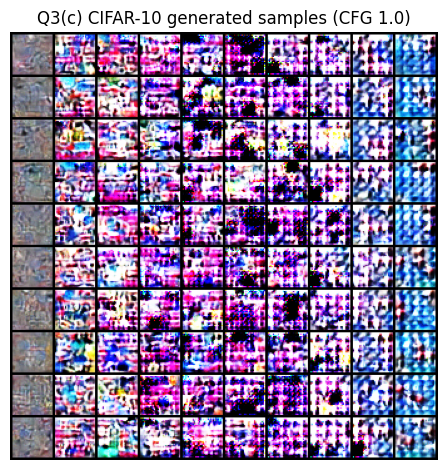

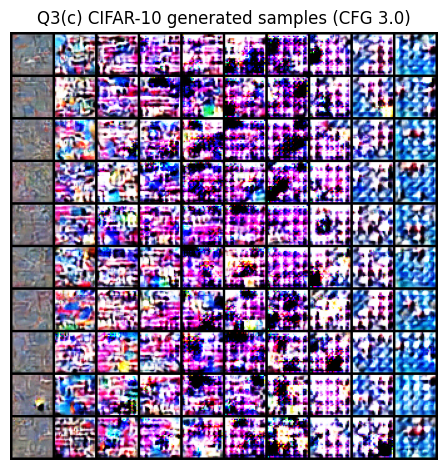

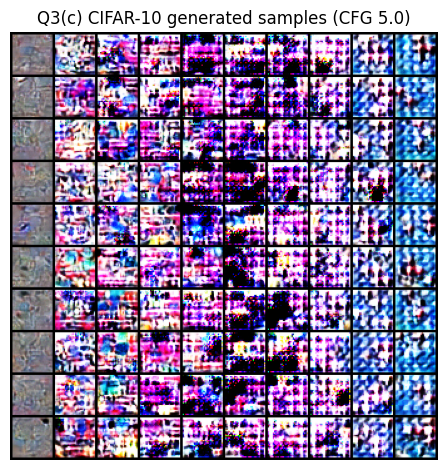

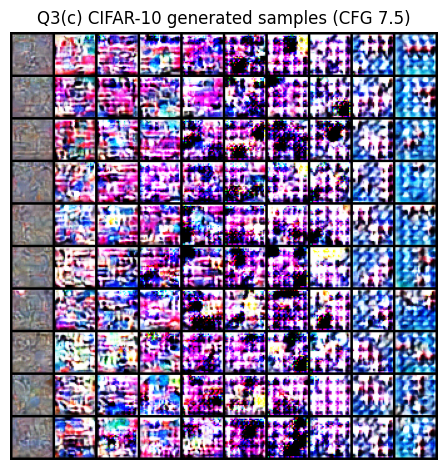

In [65]:
q3c_save_results(q3_c)